# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.



Описание входных данных:

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

### Краткий план работы:

1. Изучить общую информацию о данных


2. Провести предобработку данных:
    - определить и изучить пропущенные значения;
    - заполнить пропуски, где это уместно;
    - разобраться в причинах, которые могли привести к пропускам в данных;
    - привести данные к нужным типам.
  
  
3. Посчитать и добавить в таблицу:
    - цену квадратного метра;
    - день недели, месяц и год публикации объявления;
    - этаж квартиры; варианты — первый, последний, другой;
    - соотношение жилой и общей площади, а также отношение площади кухни к общей.
    
    
4. Провести исследовательский анализ данных и ответить на вопросы.


5. Сделать общий вывод

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
plt.rc('figure', max_open_warning = 30)
%matplotlib notebook

In [2]:
realty = pd.read_csv('datasets/real_estate_data.csv', delimiter='\t')

Первое знакомство с данными проведем с помощью метода info():

In [3]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
realty.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Колонки переименовываю на свой вкус, таким образом, чтобы название, к примеру, столбца с данными булевого типа начинались с is_

In [5]:
realty.columns = ['total_images', 'last_price', 'total_area', 'published_on',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'balconies',
       'city', 'airport_dist', 'downtown_dist',
       'parks_around3000', 'park_dist', 'ponds_around3000',
       'pond_dist', 'days_published']

In [6]:
realty.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balconies,airport_dist,downtown_dist,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [7]:
pd.set_option('display.max_columns', 25)

In [8]:
realty.head(10)

,total_images,last_price,total_area,published_on,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balconies,city,airport_dist,downtown_dist,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

Ознакомившись с данными вижу, что:

- в части колонок есть пропуски, где-то они единичные, где-то занимают небольшую часть и, следовательно, сравнительно легко могут быть заполнены, а где-то большая часть значений пропущена. Поэтому к разным колонкам будет применяться разный подход.


- существуют несоответствия типов заявленным данным, например, стобец "is_apartment", в котором предполагается булев тип, имеет dtype object. 


- столбец, содержащий даты размещения объявления, необходимо будет привести к формату datetime вместо object. Такие данные более удобны для чтения и дальнейшей работы.


- в части столбцов типа float целесообразно привести данные к целочисленному типу. например, использование float для подсчета этажей (floors_total) не имеет смысла, т.к. этажей может быть только целое количество

### Шаг 2. Предобработка данных

Получим список столбцов, в которых есть пропущенные значения, затем начнем разбирать их по одному

In [9]:
[column for column in realty.columns if len(realty[column].dropna()) < len(realty)]

['ceiling_height',
 'floors_total',
 'living_area',
 'is_apartment',
 'kitchen_area',
 'balconies',
 'city',
 'airport_dist',
 'downtown_dist',
 'parks_around3000',
 'park_dist',
 'ponds_around3000',
 'pond_dist',
 'days_published']

Первый в списке - высота потолков.

In [10]:
realty.ceiling_height.describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Данные по высоте потолков отсутствуют примерно у 40% значений. Это может быть связано с тем, что многие люди не знают высоту потолков в своих квартирах. Однако метод describe показал и другие аномалии - минимальная высота потолков 1 метр - слишком мало, туда и человек-то не пройдет, а максимальная - 100 метров - похожа больше на высоту всего дома, чем отдельного этажа. Скорее всего, таких данных немного, ведь среднее и медиана - примрно 2,7 метра - не вызывают никаких подозрений. 
Посмотрим на график "ящик с усами". Возьмем за границы высоту 2-4 метра.

<IPython.core.display.Javascript object>


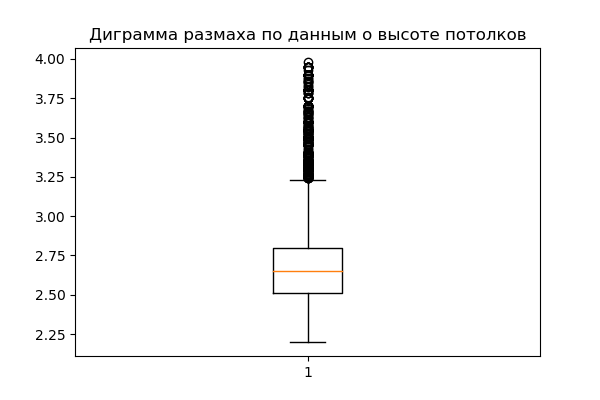

Text(0.5, 1.0, 'Диграмма размаха по данным о высоте потолков')

In [11]:
plt.figure(figsize=(6,4))
plt.boxplot(realty[(2 < realty.ceiling_height) & (realty.ceiling_height < 4)].ceiling_height)
plt.title('Диграмма размаха по данным о высоте потолков')

На графике видно, что большинство квартир имеет потолки высотой 2.5-3 метра. Тем не менее, бывают дома с действительно высокими потолками. Я хочу исключить совсем уж неправдоподобные варианты, поэтому оставлю квартиры с потолками от 2 до 10 метров. 

Посмотрим, сколько данных будет потеряно:

In [12]:
len(realty[(realty.ceiling_height <= 2) | (realty.ceiling_height >= 10)])

39

Данные распределены довольно скученно, стандартное отклонение небольшое, высота потолков - величина не особенно изменчивая, поэтому в данном случае я считаю возможным заполнить пропущенные значения медианой (как мы знаем, медиана - величина, более устойчивая к выбросам, поэтому я предпочту ее среднему). Последним шагом перед этим станет проверка корреляции между высотой потолков и ценой (почему-то мне пришла в голову гипотеза о том, что дорогие квартиры могут иметь в среднем более высокие потолки)

In [13]:
realty.last_price.corr(realty.ceiling_height)

0.08543030982842595

In [14]:
realty.total_area.corr(realty.ceiling_height)

0.09549044852366369

Корреляции, по всей видимости, нет. Заполняем пропуски

Функцию написал, ибо ниже подобную операцию еще раз делаю

In [16]:
def GetMaxCorr(column):
    max_corr = (None, 0)

    for candidate in realty.columns:
        
        if realty[candidate].dtype != 'object' and candidate != column and realty[candidate].corr(realty[column]) > max_corr[1]:
            max_corr = (candidate, realty[candidate].corr(realty[column]))
            #print(candidate, realty['ceiling_height'].corr(realty[candidate]))
              
    return max_corr

In [17]:
GetMaxCorr('ceiling_height')

('total_area', 0.09549044852366369)

Теперь убираем строки с выбросами:

In [18]:
def FillMissingDataFromCorrelatingColumn(row, column_to_fill, column_to_compare='total_area', restrict_cycles=30):
    
    """
    [v3]
    Принимает на вход строку датафрейма, название столбца с пропусками и опцинально - 
    название столбца, из которого будем выбирать данные (дефолтное - общая площадь).
    Если значение в строке пропущено, берет значение общей площади, после чего выбирает из общей таблицы такие квартиры, 
    чья общая площадь отличается от искомой не более, чем на значение range_for_calculations (дефолтное - 5).
    Если получившаяся выборка содержит менее 10 элементов, повторяет поиск с увеличенным разбросом 
    (шаг - 5), пока выборка не достигнет требуемого размера (дабы не считать медиану по 1-2 квартирам, 
    т.к. получится нерепрезентативно). Не более 30 попыток (дефолт, можно передать другое значение),
    дабы не случилось зацикливание.
    Затем считает медиану "пропущенного" столбца у получившейся выборки и присваивает это значение исходной строке.
    """

    range_for_calculations = 5
    total = row[column_to_compare]
    preliminary_data = realty[(total - range_for_calculations < realty[column_to_compare]) & \
                         (realty[column_to_compare] < total + range_for_calculations)].dropna()[column_to_fill]

    while len(preliminary_data) < 10 and restrict_cycles > 0:

        restrict_cycles -= 1
        range_for_calculations += 5
        preliminary_data = realty[(total - range_for_calculations < realty[column_to_compare]) & \
                             (realty[column_to_compare] < total + range_for_calculations)].dropna()[column_to_fill]
        
    near_median = preliminary_data.median()
    row[column_to_fill] = near_median
    
    return row

Вызов функции:

In [19]:
realty[realty.ceiling_height.isna()] = realty[realty.ceiling_height.isna()] \
                                    .apply(FillMissingDataFromCorrelatingColumn, axis=1, args=('ceiling_height',))

In [20]:
realty = realty.query('2 < ceiling_height < 10')

**v2** я учту, но здесь пусть остается так

Переходим к столбцу с общим числом этажей

In [21]:
realty.floors_total.describe()

count    23570.000000
mean        10.675944
std          6.593572
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Пропусков немного, причем это неслучайные пропуски - число этажей в доме не зависит ни от каких других данных. Лучшим выходом будет просто удалить эти строки. В остальном данные по столбцу подозрений не вызывают.

In [22]:
realty.dropna(subset=['floors_total'], inplace=True) # реиндекс сделаю позже, пока это не сильно важно

Теперь рассмотрим данные по площади квартир

In [23]:
realty.living_area.describe()

count    21704.000000
mean        34.445381
std         21.907795
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Нам был предоставлен план работы (тот, что внизу). По нему предлагается сейчас заполнить пропуски, а на 4 шаге строить графики. Я буду строить график сейчас, потому что здесь он прям нужен и полезен. В случае чего я в дальнейшем сошлюсь на этот график либо продублирую. 

<IPython.core.display.Javascript object>


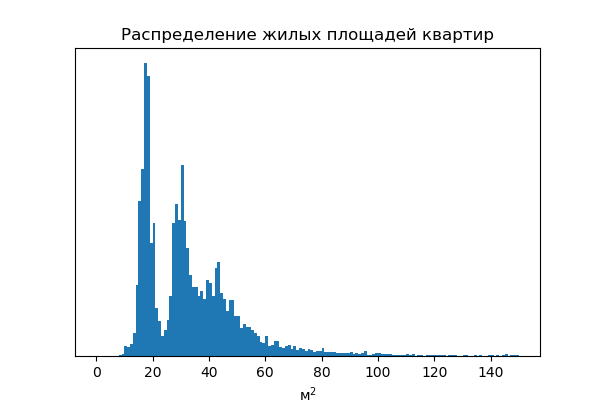

Text(0.5, 0, 'м$^2$')

In [24]:
plt.figure(figsize=(6,4))
plt.hist(realty.living_area.dropna(), bins=150, range=(0, 150))
plt.title('Распределение жилых площадей квартир')
plt.yticks(ticks=None, labels=None)
plt.tick_params(axis='y', which='major',length=0, labelleft=False)
plt.xlabel('м$^2$')

Здесь и далее я иногда буду убирать части графика, которые отвлекают фокус внимания. Конкретно здесь не важно, сколько именно квартир пришлось на конкретное значение площади, важна сама форма распределения.

На графике видим три пика - очевидно, типичные площади одно-, двух- и трехкомнатных квартир, соответственно. Типичные площади квартир от 17 до 80 кв.м., предложения с большей площадью редки.

Большие квартиры я могу себе вообразить, а вот на двух квадратных метрах жить представляется невозможным. Посмотрим на строки с необычно малыми площадями:

In [25]:
realty[realty.living_area < 8]

,total_images,last_price,total_area,published_on,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balconies,city,airport_dist,downtown_dist,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,2.70,17.0,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.00,6.0,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.60,5.0,6.0,1,NaN,False,False,17.0,NaN,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,2.60,25.0,5.0,8,NaN,True,False,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
19251,19,4050000.0,33.0,2018-10-15T00:00:00,1,2.50,22.0,6.5,21,NaN,False,False,18.0,NaN,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,2.55,24.0,2.0,22,NaN,True,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.50,9.0,5.4,1,NaN,False,False,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.00,8.0,3.0,8,NaN,False,False,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


Общая площадь квартир выглядит весьма ординарно, по-видимому, такие значения жилой площади ввели ошибочно.

Посмотрим на корреляцию между жилой и общей площадью:

In [26]:
realty.living_area.corr(realty.total_area)

0.9390855124645218

Видим предсказуемо сильную положительную корреляцию. Это можно использовать для заполнения пропусков.

Напишем функцию, которая будет заполнять пропущенное значение жилой площади в зависимости от общей площади квартиры:

In [27]:
realty[realty.living_area.isna()] = realty[realty.living_area.isna()] \
                                    .apply(FillMissingDataFromCorrelatingColumn, axis=1, args=('living_area',))

Переходим к колонке is_apartment, которая содержит данные о том, является ли помещение апартаментами.

In [28]:
realty.is_apartment.value_counts()

False    2715
True       47
Name: is_apartment, dtype: int64

Нужно преобразовать тип в булев. Однако если сделать это сразу, пропущенные значения заменятся на True. Поэтому перед конвертацией заполним пропуски.

Я буду использовать заполнение дефолтными значениями. Соображения на этот счет следующие:

1) Я сходил, собственно, на сайт Яндекс.Недвижимости и посмотрел долю апартаментов в общем числе объявлений по Петербургу и области. Их немного - около 4%. Доля апартаментов в нашей таблице (**из тех, где этот параметр указан**) около 2%, что меньше, но данные архивные, возможно, с тех времен апартаменты стали популярнее (кризис прошел, знаете ли).

2) Данные булева типа - категориальные, мы не можем использовать методы вроде заполнения характерными значениями. При этом пропуски носят неслучайный характер - данный параметр не зависит не от каких других значений. То есть мы можем либо оставить как есть, либо записать пропуски как False - даже частично пометив квартиры как апартаменты "методом тыка", мы сильно исказим данные.

3) При этом можно отметить, что поскольку продавцы большинства квартир продают не апартаменты, многие не станут отмечать этот параметр вовсе, думаю, некоторые вообще не в курсе их существования. Именно это может быть причиной столь большого количества пропусков в этой колонке - люди просто не стали заполнять значения.

In [29]:
realty.is_apartment.fillna(False, inplace=True)

In [30]:
realty.is_apartment = realty.is_apartment.astype('bool') # преобразование типов

In [31]:
realty.is_apartment.dtype # проверка

dtype('bool')

In [32]:
realty.kitchen_area.corr(realty.total_area)

0.6084710054012298

Для заполнения пропусков по площади кухни справедливы все те же соображения, которые отмечались для жилой площади (графики я тоже посмотрел, но в данном случае не буду засорять тетрадь). Повторно используем написанную выше функцию, передав в качестве параметра соответствубщий столбец.

In [33]:
realty[realty.kitchen_area.isna()] = realty[realty.kitchen_area.isna()] \
                                    .apply(FillMissingDataFromCorrelatingColumn, axis=1, args=('kitchen_area',))

Переходим к столбцу с балконами. Здесь пропущены более половины значений. Пропуски, вероятно, появились по той же причине, что и в столбце is_apartments - люди, не имеющие балкона, не заполнили значения. Поэтому будет логично заполнить такие пропуски нулями. Кроме того, целесообразно изменить тип данных. Количество балконов всегда будет целым числом, нет смысла хранить такие данные во float.

In [34]:
realty.balconies.fillna(0, inplace=True)

In [35]:
realty.balconies = pd.to_numeric(realty.balconies, downcast='unsigned') # т.к. число балконов не может быть отрицательным

Следующая колонка - город (или деревня, у меня все городом будет называться, так короче => удобнее)

In [36]:
len(realty[realty['city'].isna()])

48

Всего менее 50 пропусков, восстановить их не получится. Была идея попробовать использовать какую-то аппроксимацию, допустим, по расстоянию до центра города выбрать похожие строки и заполнить населенный пункт по данным оттуда, но в данном случае, в отличие от площади квартиры, данные категориальные, пропуски, опять же, неслучайные, а на одном и том же расстоянии от центра, но в разных направлениях, могут располагаться разные населенные пункты. В общем, данных не хватает, а поскольку пропусков мало, считаю целесообразным их удалить. Потеря в любом случае небольшая.

In [37]:
realty.dropna(subset=['city'], inplace=True)

Сделаем реиндекс еще:

In [38]:
realty.reset_index(drop=True, inplace=True)

Данные о населенных пунктах вводили пользователи, возможны дубликаты. Проверим эту гипотезу:

In [39]:
realty.city.unique()[:30]

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов'], dtype=object)

Где-то "поселок", где-то "посёлок", данные неконсистентны. С помощью функции создадим новый столбец со стандартизированными именами населённых пунктов (изначально планировал использовать стеммер, но результаты выходили не очень удачными, с функцией получилось быстро и весьма эффективно)

In [40]:
block_list = ['городского', 'городской', 'типа', 'имени', 'коттеджный', 'поселок', 'деревня', 'садовое', 'товарищество', 
              'село', 'при', ' железнодорожной', ' станции', 'некоммерческое'] 

In [41]:
def GetShortCityName(row):
    """
    Принимает на вход строку, в которой разбирает название населенного пункта:
    1) Переводит название в нижний регистр
    2) Заменяет ё на е, чтобы исключить дублирование названий
    3) Разбирает строку на слова, исключает из нее типы названий нас. пунктов и возвращает получившееся название
    """
    
    city_name = row['city']
    parse_string = city_name.lower().replace('ё', 'е').split()
    delete_name_prefix = [word for word in parse_string if word not in block_list]
    
    short_name = ' '.join(delete_name_prefix)
    
    return short_name

In [42]:
realty['short_city_name'] = realty.apply(GetShortCityName, axis=1)

Запросим список колонок с оставшимися пропусками

In [43]:
[column for column in realty.columns if len(realty[column].dropna()) < len(realty)]

['airport_dist',
 'downtown_dist',
 'parks_around3000',
 'park_dist',
 'ponds_around3000',
 'pond_dist',
 'days_published']

In [44]:
len(realty[realty['days_published'].isna()])

3160

Пропуски в столбце с данными о дате публикации объявления скорее всего вызваны тем, что не все квартиры были проданы - соответственно, нельзя посчитать количество дней от момента публикации до снятия. В этом случае целесообразно оставить пропуски.

Что касается данных по объектам (имею в виду парки, пруды и пр.) - восстановить их не представляется возможным, поскольку значения этих столбцов зависят от географического положения квартиры, а такой информации у нас нет. Чтобы как-то отметить отсутствие данных, заполним количество объектов нулем, а расстояния до объектов дефолтным значением -1, и при дальнейших расчетах будем учитывать этот факт.


In [45]:
GetMaxCorr('downtown_dist')

('airport_dist', 0.2711354468678441)

In [46]:
len(realty[(realty.downtown_dist.isna()) & ~(realty.airport_dist.isna())])

1

In [48]:
realty[['airport_dist',
 'downtown_dist',
 'park_dist',
 'pond_dist',]] = \
realty[['airport_dist',
 'downtown_dist',
 'park_dist',
 'pond_dist',]].fillna(-1)

In [49]:
realty[['parks_around3000','ponds_around3000',]] = \
realty[['parks_around3000','ponds_around3000',]].fillna(0)

Настало время еще раз обобщить информацию о таблице:

In [50]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23522 entries, 0 to 23521
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_images      23522 non-null  int64  
 1   last_price        23522 non-null  float64
 2   total_area        23522 non-null  float64
 3   published_on      23522 non-null  object 
 4   rooms             23522 non-null  int64  
 5   ceiling_height    23522 non-null  float64
 6   floors_total      23522 non-null  float64
 7   living_area       23522 non-null  float64
 8   floor             23522 non-null  int64  
 9   is_apartment      23522 non-null  bool   
 10  is_studio         23522 non-null  bool   
 11  is_open_plan      23522 non-null  bool   
 12  kitchen_area      23522 non-null  float64
 13  balconies         23522 non-null  uint8  
 14  city              23522 non-null  object 
 15  airport_dist      23522 non-null  float64
 16  downtown_dist     23522 non-null  float6

Займемся конверсией типов данных. Столбцы, чьи значения могут содерждать только положительные целые значения приведем к беззнаковому типу:

In [51]:
for column in ['total_images','rooms', 'floors_total','floor','parks_around3000','ponds_around3000']:
    realty[column] = pd.to_numeric(realty[column], downcast='unsigned')

В некоторые столбцы мы записали -1, их приведем к целочисленному типу (точность выше метра там все равно не нужна):

In [52]:
for column in ['airport_dist','downtown_dist','park_dist','pond_dist']:
    realty[column] = pd.to_numeric(realty[column], downcast='integer')

Высоту потолков приведем к типу float - сейчас там object, и здесь нам нужна точность выше метра:

In [53]:
realty.ceiling_height = pd.to_numeric(realty.ceiling_height, downcast='float')

Осталось привести столбец с датами к формату datetime:

In [54]:
realty.published_on = pd.to_datetime(realty.published_on)

Теперь удалим дубликаты

In [55]:
realty.drop_duplicates(inplace=True) # таковых не нашлось, так что без реиндекса

Посмотрим обобщенную информацию по получившейся таблице:

In [56]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23522 entries, 0 to 23521
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   total_images      23522 non-null  uint8         
 1   last_price        23522 non-null  float64       
 2   total_area        23522 non-null  float64       
 3   published_on      23522 non-null  datetime64[ns]
 4   rooms             23522 non-null  uint8         
 5   ceiling_height    23522 non-null  float32       
 6   floors_total      23522 non-null  uint8         
 7   living_area       23522 non-null  float64       
 8   floor             23522 non-null  uint8         
 9   is_apartment      23522 non-null  bool          
 10  is_studio         23522 non-null  bool          
 11  is_open_plan      23522 non-null  bool          
 12  kitchen_area      23522 non-null  float64       
 13  balconies         23522 non-null  uint8         
 14  city              2352

### Вывод

В некоторых столбцах таблицы отсутствовало около половины значений. Это вероятнее всего было связано с тем, что данные заполняли пользователи, и кто-то не указал высоту потолков, кто-то отсутствие балкона или площадь кухни. Там, где возможно, пропуски были заполнены значениями, характерными для похожих объектов, в других случаях были использованы дефолтные значения. В столбце days_published пропуски намеренно были оставлены, поскольку отсутствие значения в этом случае сигнализирует о том, что квартира еще не была продана.

Данные в большинстве столбцов были приведены к минимально возможному для их представления типу. Был применен метод для удаления дубликатов, хотя таковых не нашлось. Названия населенных пунктов были приведены к стандартному виду и добавлены в отдельный столбец.

В таком виде таблица готова для дальнейшего анализа.

### Шаг 3. Посчитайте и добавьте в таблицу

Добавим в таблицу необходимые данные

Цена квадратного метра:

In [57]:
realty['price_per_sqm'] = realty.last_price / realty.total_area

День недели, месяц и год публикации объявления можно получить как соответствующие атрибуты данных столбца published_on, добавление отдельных колонок в данном случае будет излишним.

Этаж квартиры: варианты — первый, последний, другой. Реализуется путем применения функции + конвертация в категорийные данные для ускорения работы и экономии памяти.

In [58]:
def GetFloorKind(row):
    """
    Принимает строку, возвращает категорию этажа: первый, последний или другой
    """

    if row.floor == 1:
        kind = 'first'
    elif row.floor == row.floors_total:
        kind = 'top'
    else:
        kind = 'other'
        
    return kind

In [59]:
realty['floor_kind'] = realty.apply(GetFloorKind, axis=1).astype('category')

Соотношение жилой и общей площади:

In [60]:
realty['living_to_total'] = realty.living_area / realty.total_area

Отношение площади кухни к общей:

In [61]:
realty['kitchen_to_total'] = realty.kitchen_area / realty.total_area

Вывода в данном пункте нет, ибо мы просто добавили данные. Переходим к следующему шагу.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучем данные по общей площади квартир:

In [62]:
realty.total_area.describe()

count    23522.000000
mean        60.258869
std         35.141860
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Максимум довольно высокий, построим график "ящик с усами", чтобы оценить количество выбросов

<IPython.core.display.Javascript object>


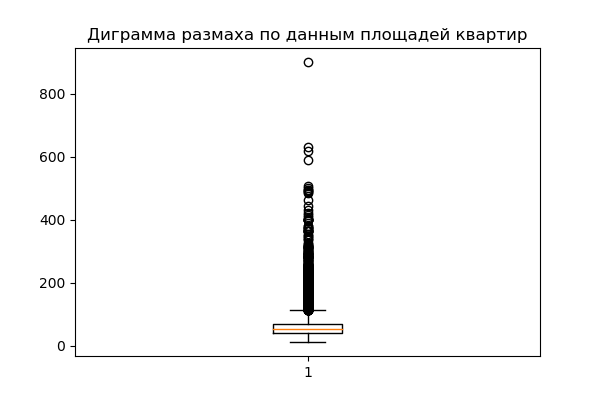

Text(0.5, 1.0, 'Диграмма размаха по данным площадей квартир')

In [63]:
plt.figure(figsize=(6,4))
plt.boxplot(realty.total_area)
plt.title('Диграмма размаха по данным площадей квартир')
# тут намеренно не стал делать ylim, т.к. хотел посмотреть на выбросы около максимума

Видно единичный выброс в районе 900 кв.м., большинство же квартир имеют площадь ниже 150 кв.м.
Построим гистограмму распределения:

<IPython.core.display.Javascript object>


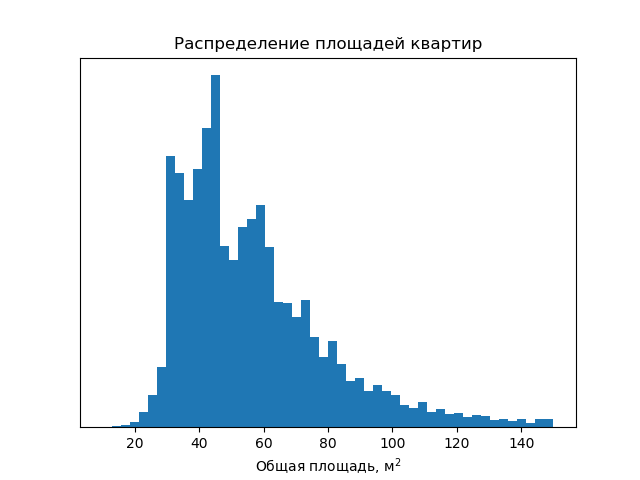

In [64]:
plt.figure()
plt.hist(realty.total_area, bins=50, range=(10,150))
plt.title('Распределение площадей квартир')
plt.xlabel('Общая площадь, м$^2$')
plt.tick_params(axis='y', which='major',length=0, labelleft=False)

Пики графика приходятся на площади примерно в 30, 45 и 60 кв.м. (можно навести мышь на график, чтобы убедиться). Это соответствует площадям одно-, двух- и трехкомнатных квартир соответственно. Небольшой пик в районе 74-80 кв.м., вероятно, типичная 4-комнатная квартира, чуть меньше этого значения третий квантиль. В целом картина ожидаемая - квартир с большой площадью мало, тем не менее, считаю целесообразным убрать значения более 400 кв.м., поскольку это скорее выбросы. Их немного:

In [65]:
len(realty[realty.total_area > 400])

19

In [66]:
realty = realty[realty.total_area < 400]

Цены объявлены в рублях. Поскольку данные в этом столбце представлены типом float (т.е. имеют достаточно точное представление после запятой), и менять этот тип я не планирую, для удобства анализа столбец делим на 1000, и **все дальнейшие вычисления по ценам будем проводить в тысячах рублей**

In [67]:
realty['last_price'] = realty.last_price / 1000

In [68]:
realty.last_price.describe() # в тысячах руб.

count     23500.000000
mean       6388.321514
std        8232.996232
min          12.190000
25%        3400.000000
50%        4638.000000
75%        6758.276500
max      330000.000000
Name: last_price, dtype: float64

Видим, что среднее весьма существенно отличается от медианы в большую сторону. Кроме того, наблюдаем очень большую стандартную девиацию. Можно предположить, что данные в целом валидны, однако присутствует значительное количество выборов - необычно дорогих квартир - которые увеличивают подверженное влиянию подобных явлений среднее, но не так сильно влияют на медиану. Для проверки этой гипотезы построим график "ящик с усами".

Верхний предел цены установим в 15 миллионов, чтобы избежать засорения пространства за "усами" многочисленными (хоть и составляющими весьма небольшую часть от общей выборки) выбросами. (Ориентируемся на 3 квантиль, но берем с запасом).


<IPython.core.display.Javascript object>


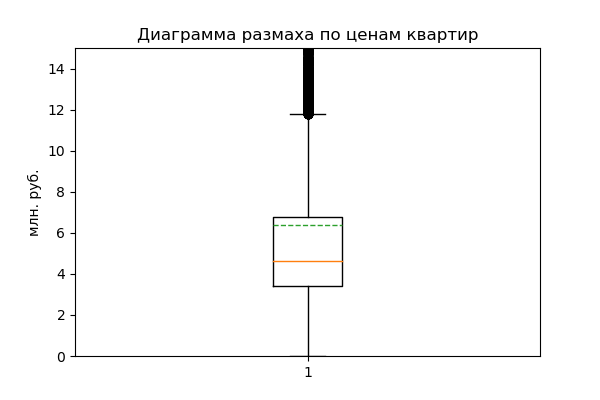

Text(0, 0.5, 'млн. руб.')

In [69]:
plt.figure(figsize=(6,4))
plt.gca().set_ylim(top=15000)
plt.boxplot(realty.last_price, showmeans=True, meanline=True)
plt.title('Диаграмма размаха по ценам квартир')
plt.gca().set_yticklabels([0,2,4,6,8,10,12,14])
plt.ylabel('млн. руб.')

Видим, что медиана, как и ожидалось, расположена ниже среднего, а сверху "уса" присутствуют многочисленные выбросы. Обратим также внимание, что нижний ус практически касается нуля, чего у данных по ценам на недвижимость быть не должно (выше по описательным данным можно видеть более точную цифру - минимальная цена квартиры составила около 12 тыс. руб.)

Изучем распределение подробнее, построив гистограмму

<IPython.core.display.Javascript object>


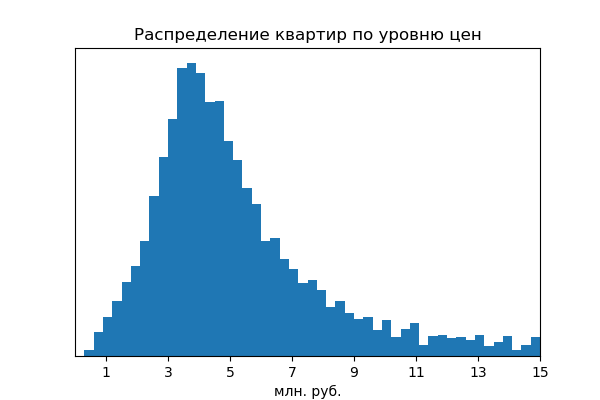

In [70]:
plt.figure(figsize=(6,4))
plt.hist(realty.last_price, bins=50, range=(0,15000))
plt.title('Распределение квартир по уровню цен')
plt.xlim(0,15000)
plt.xticks([1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000], labels=[1, 3, 5, 7, 9, 11, 13, 15])
plt.xlabel('млн. руб.')
plt.tick_params(axis='y', which='major', length=0, labelleft=False)

Форма графика похожа на ожидаемое для таких данных нормальное распределение - пик наблюдается около 3,7 млн, в обе стороны от пика идет снижение, квартир дороже 30 миллионов очень мало, дороже 40 практически нет (на графике выше этого не видно, ибо сначала я ограничивал абсциссу как раз 30-40 миллионами, а выше перед вами "оптимизированная для просмотра" версия). Важно отметить, что это ниже медианы, и уж тем более ниже среднего. Следовательно, дорогие квартиры сильно влияют на распределение. Если оставим все как есть, можем получить неверные выводы. Также имеются подозрительно дешевые квартиры.

Предварительно хочу посмотреть, что за квартиры имеют слишком малую цену

In [71]:
realty.sort_values('last_price').head(10)

,total_images,last_price,total_area,published_on,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,...,airport_dist,downtown_dist,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published,short_city_name,price_per_sqm,floor_kind,living_to_total,kitchen_to_total
8732,7,12.19,109.0,2019-03-20,2,2.750,25,32.0,25,False,False,False,...,36421,9176,1,805,0,-1,8.0,санкт-петербург,111.834862,top,0.293578,0.371560
14802,5,430.00,54.0,2018-06-26,2,2.635,3,31.0,3,False,False,False,...,-1,-1,0,-1,0,-1,44.0,станции свирь,7962.962963,top,0.574074,0.153704
17332,7,430.00,30.4,2019-04-22,1,2.560,2,16.0,1,False,False,False,...,-1,-1,0,-1,0,-1,NaN,сланцы,14144.736842,first,0.526316,0.197368
16161,18,440.00,40.0,2018-07-10,1,2.700,5,18.4,1,False,False,False,...,-1,-1,0,-1,0,-1,45.0,старополье,11000.000000,first,0.460000,0.226250
16106,14,450.00,38.5,2018-07-11,2,2.650,2,18.0,1,False,False,False,...,-1,-1,0,-1,0,-1,45.0,вахнова кара,11688.311688,first,0.467532,0.233766
9516,7,450.00,43.4,2018-08-31,2,2.700,5,30.3,3,False,False,False,...,-1,-1,0,-1,0,-1,96.0,старополье,10368.663594,other,0.698157,0.126728
17549,0,450.00,36.5,2018-02-01,1,2.700,5,17.3,4,False,False,False,...,-1,-1,0,-1,0,-1,120.0,ям-тесово,12328.767123,other,0.473973,0.232877
5658,7,450.00,42.0,2017-07-31,2,2.700,1,23.0,1,False,False,False,...,-1,-1,0,-1,0,-1,233.0,будогощь,10714.285714,first,0.547619,0.138095
23309,11,470.00,44.5,2018-07-02,2,2.650,2,28.0,2,False,False,False,...,-1,-1,0,-1,0,-1,298.0,сланцы,10561.797753,top,0.629213,0.168539
18733,1,470.00,41.0,2018-02-11,1,2.700,5,32.0,3,False,False,False,...,-1,-1,0,-1,0,-1,46.0,выскатка,11463.414634,other,0.780488,0.219512


Даже не апартаменты. 

Теперь то же самое для самых дорогих квартир:

In [72]:
realty.sort_values('last_price', ascending=False).head(10)

,total_images,last_price,total_area,published_on,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,...,airport_dist,downtown_dist,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published,short_city_name,price_per_sqm,floor_kind,living_to_total,kitchen_to_total
1429,19,330000.0,190.0,2018-04-04,3,3.500,7,95.0,5,False,False,False,...,23011,1197,3,519,3,285,233.0,санкт-петербург,1.736842e+06,other,0.500000,0.210526
22661,18,289238.4,187.5,2019-03-19,2,3.370,6,63.7,6,False,False,False,...,22494,1073,3,386,3,188,NaN,санкт-петербург,1.542605e+06,top,0.339733,0.161067
16347,17,245000.0,285.7,2017-04-10,6,3.350,7,182.8,4,False,False,False,...,33143,6235,3,400,3,140,249.0,санкт-петербург,8.575429e+05,other,0.639832,0.104305
8839,13,190870.0,268.0,2016-03-25,3,3.250,8,132.0,7,False,False,False,...,32440,5297,0,-1,2,198,901.0,санкт-петербург,7.122015e+05,other,0.492537,0.149254
19724,20,180000.0,347.0,2015-01-21,8,3.900,6,260.0,3,False,False,False,...,23962,3794,2,537,3,501,834.0,санкт-петербург,5.187320e+05,other,0.749280,0.129683
19017,20,160000.0,243.0,2018-11-12,5,3.250,5,145.0,4,False,False,False,...,22640,555,3,285,1,200,18.0,санкт-петербург,6.584362e+05,other,0.596708,0.135802
2525,16,159984.0,242.4,2015-08-27,4,3.850,9,131.0,7,False,False,False,...,21946,2242,1,679,1,227,501.0,санкт-петербург,6.600000e+05,other,0.540429,0.082508
16381,12,159000.0,260.0,2017-04-04,4,3.250,5,180.0,4,False,False,False,...,21740,436,2,138,3,620,178.0,санкт-петербург,6.115385e+05,other,0.692308,0.115385
1020,20,155000.0,310.0,2018-10-12,5,5.300,3,190.0,3,False,False,False,...,24899,4785,0,-1,1,603,NaN,санкт-петербург,5.000000e+05,top,0.612903,0.203226
7799,11,150000.0,230.0,2017-10-25,8,3.225,8,220.0,8,False,False,False,...,25525,5845,2,116,0,-1,135.0,санкт-петербург,6.521739e+05,top,0.956522,0.080435


Ожидаемо большие площади и потолки аж по 20 метров. Выбрасывать такие данные мне не хочется, в конце концов, кто-то может продавать подвал. Или дворец. Поэтому помечу такие данные, и в дальнейшем посчитаю что-нибудь отдельно по ним.

Установим нижний предел цены в 1 млн., верхний в 15 млн. руб.

Также я хочу избавиться от совсем дешевых квартир (дешевле 500 тысяч), поскольку это больше похоже на ошибку в данных, вряд ли кто-то будет продавать настолько дешево.

In [73]:
realty = realty[realty.last_price > 500]

Теперь пометим квартиры дешевле 1,5 миллионов как слишком дешевые, а дороже 15, как слишком дорогие. Это можно будет использовать при анализе.

In [74]:
realty['price_too_low'] = realty.last_price < 1500
realty['price_too_high'] = realty.last_price > 15000

Теперь можно посмотреть, как много у нас таких данных!

In [75]:
print('Очень дорогих квартир: {:.2%}'.format(realty.price_too_high.mean()))
print('Очень дешевых квартир: {:.2%}'.format(realty.price_too_low.mean()))

Очень дорогих квартир: 4.98%
Очень дешевых квартир: 2.67%


Теперь изучим данные по числу комнат:

In [76]:
realty.rooms.describe()

count    23482.000000
mean         2.066732
std          1.066273
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

0 комнат - это интересно и необычно! 19 тоже. 

Стоит отметить, что квантили приходятся как раз на типичное количество комнат - одна, две, три соответственно.

Посмотрим на ящик с усами для этого столбца, чтобы оценить количество выбросов

<IPython.core.display.Javascript object>


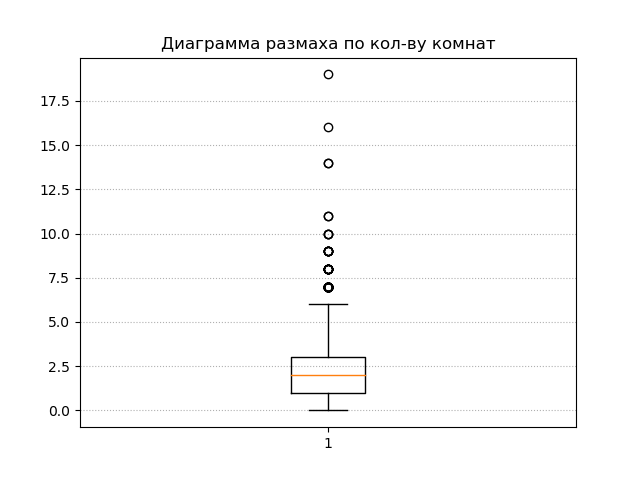

In [77]:
plt.figure()
plt.boxplot(realty.rooms)
plt.title('Диаграмма размаха по кол-ву комнат')
plt.grid(axis='y',linestyle=':')

Получилось на удивление неплохо! Небольшое кол-во квартир с большим числом комнат меня не очень беспокоит, олигархам и депутатам ведь тоже надо где-то жить, а вот нулевое количество комнат - непорядок.

Посмотрим, что за квартиры без комнат

In [78]:
realty[realty.rooms == 0].head(10)

,total_images,last_price,total_area,published_on,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,...,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published,short_city_name,price_per_sqm,floor_kind,living_to_total,kitchen_to_total,price_too_low,price_too_high
144,1,2450.0,27.00,2017-03-30,0,2.600,24,15.50,2,False,True,False,...,0,-1,0,-1,181.0,мурино,90740.740741,other,0.574074,0.222222,False,False
347,4,2320.0,25.00,2017-09-27,0,2.575,14,17.00,1,False,False,True,...,0,-1,0,-1,45.0,кудрово,92800.000000,first,0.680000,0.240000,False,False
437,8,2480.0,27.11,2018-03-12,0,2.550,17,24.75,4,False,True,False,...,0,-1,2,982,64.0,санкт-петербург,91479.158982,other,0.912947,0.221321,False,False
504,0,3375.0,34.40,2017-03-28,0,2.625,26,24.30,19,False,False,True,...,0,-1,1,593,430.0,парголово,98110.465116,other,0.706395,0.232558,False,False
603,2,1850.0,25.00,2019-02-20,0,2.575,10,17.20,7,False,True,False,...,0,-1,0,-1,29.0,шушары,74000.000000,other,0.688000,0.240000,False,False
691,12,2500.0,24.10,2017-12-01,0,2.750,25,17.50,21,False,True,False,...,0,-1,0,-1,201.0,кудрово,103734.439834,other,0.726141,0.248963,False,False
710,5,1500.0,17.00,2017-06-07,0,2.700,9,12.00,1,False,True,False,...,0,-1,0,-1,40.0,шушары,88235.294118,first,0.705882,0.352941,False,False
774,9,2600.0,26.10,2018-02-20,0,2.600,18,17.20,8,False,False,True,...,0,-1,0,-1,45.0,мурино,99616.858238,other,0.659004,0.229885,False,False
833,14,1900.0,35.00,2017-04-14,0,2.700,5,15.00,3,False,False,True,...,0,-1,0,-1,7.0,новый свет,54285.714286,other,0.428571,0.228571,False,False
940,5,2200.0,23.00,2016-09-27,0,2.550,27,18.00,7,False,False,True,...,0,-1,0,-1,483.0,мурино,95652.173913,other,0.782609,0.232609,False,False


Видно, что в этих строках содержится много данных, заполненных нами в предыдущих шагах. В свете этого, и с учетом, того, что таких данных сравнительно немного, считаю возможным избавиться от них, дабы не портить статистику.

In [79]:
realty = realty[realty.rooms < 15]
realty.reset_index(drop=True, inplace=True)

**v2** Поменял, поставил ограничение в 15 комнат. Их там все равно немного. Но в городе много богатых, почему нет. Оставим хотя бы так

**v2.1** Интересно, а если 0 комнат это студии, то можно поставить для таких строк is_apartment == True? Или это отдельная категория жилья? Риэлтор из меня не очень, да. Столбец тот не нужен для анализа, поэтому я не стал заморачиваться.

Теперь можно строить гистограмму

<IPython.core.display.Javascript object>


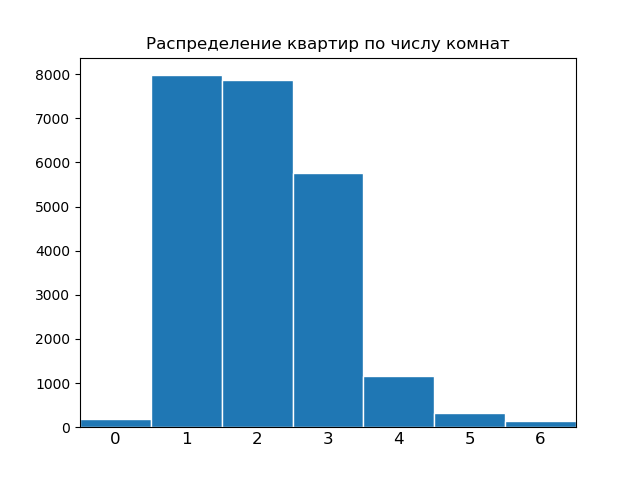

In [80]:
plt.figure()
plt.hist(realty.rooms, bins=7, range=(0,7), edgecolor='white')
plt.xlim(0,7)
plt.title('Распределение квартир по числу комнат')
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5], labels=[0,1,2,3,4,5,6], fontsize='large')
plt.tick_params(axis='x', which='major',length=0)

Теперь проанализируем данные по высоте потолков:

In [81]:
realty.ceiling_height.describe()

count    23480.000000
mean         2.728462
std          0.248144
min          2.200000
25%          2.600000
50%          2.680000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

Этим столбцом мы занимались ранее, поэтому с ним все хорошо. Ограничимся гистограммой:

In [82]:
def DrawHist(column, scope=2, nan_present=False, has_negatives=True, is_from_table=True, second_datum=None, 
             descr='не указан', restrict_right=None, restrict_top=None, kind='step'):
    
    """
    Построение гистограммы по заданным параметрам
    
    -----
    Описание:
    Рисует гистограмму по заданному столбцу. Также в функцию встроен слайдер, позволяющий контролировать 
    число bins.
    
    ВНИМАНИЕ! По неведомой причине слайдер срабатывает не всегда. В случае неотзывчивости слайдера следует прогнать 
    ячейку с вызовом функции повторно. С третьего раза обычно работает как надо.
    
    КРОМЕ ТОГО:
    При массовом прогоне (run all в различных вариациях) ячейки с интерактивом неотзывчивы, необходимо вручную
    повторить исполнение
    -----
    Parameters:
    
    column - столбец (если флаг is_from_table в состоянии True) ИЛИ Series для построения графика
    
    scope - определяет размер среза в межквантильных размахах (по умолчанию - 2)
    
    nan_present - предназначен для корректной обработки данных с пропусками. Если передано True, самостоятельно
    вызовет метод dropna() для переданных данных
    
    has_negatives - предназначен для более корректного отображения столбцов с только положительными данными
    (чтобы левая половина не была пустая)
    
    is_from_table - при значении False будет считать данные отдельным объектом Series, в ином случае обрабатывает аргумент
    column как соответствующий столбец датафрейма realty
    
    second_datum - предназначен для одновременного отображения двух Series на одном графике. Запрещено передавать аргумент
    совместно с флагом is_from_table == True
    
    descr - принимает небольшую строку для отображения в названии графика. По умолчанию "не указан"
    
    restrict_right - предназначен для ручного ограничения оси абсцисс в случае "длинного хвоста" справа. Принимает числа
    
    restrict_top - предназначен для ручного ограничения оси ординат в случае значитального расхождения масштабов
    данных. Принимает числа
    
    kind - предназначен для ручного изменения типа графика. ТОЛЬКО для графиков с двумя источниками данных!
    Принимает аргументы, ожидаемые пераметром histtype в matplotlib.axes.Axes.hist
    
    Функция UpdateBins - отвечает за перерисовку графика при взаимодействии с виджетом. Вроде входящий аргумент
    можно и удалить, кол-во bins все равно берется как аргумент объекта Slider. Но я не уверен, а ломать не хочу.
    В остальном там реализована примерно та же логика, что и у основной функции, за исключением некоторых строк, которые
    вычисляют общие переменные (квантили и т.п.)

    """
    
    fig, ax = plt.subplots()
    bins = 15
    subplots = [axis for axis in fig.axes if isinstance(axis, plt.Subplot)]
    plt.subplots_adjust(left=0.25, bottom=0.25)
    main_plot = subplots[0]
    slider_ax = plt.axes([0.25, 0.15, 0.65, 0.03])
    
    if is_from_table:
        slider = Slider(slider_ax, 'Bins', 5, 35, valinit=15, valstep=1)
        quantiles = realty[column].quantile([0.25, 0.75])
        IQR = quantiles.iloc[1] - quantiles.iloc[0]
        lower_bound = quantiles.iloc[0] - scope*IQR  
        upper_bound = quantiles.iloc[1] + scope*IQR
        
        if second_datum is None:
            if nan_present:
                main_plot.hist(realty[column].dropna(), range=(lower_bound, upper_bound), bins=bins)
            else:
                main_plot.hist(realty[column], range=(lower_bound, upper_bound), bins=bins)
            main_plot.set_title('Распределение по столбцу {}'.format(column))
        else:
            raise ValueError('Cannot pass two arguments from table')
            
    else:
        slider = Slider(slider_ax, 'Bins', 5, 105, valinit=15, valstep=5)
        if second_datum is None:
            if nan_present:
                main_plot.hist(column.dropna(), bins=bins*10)
            else:
                main_plot.hist(column, bins=bins*10)
            main_plot.set_title('Распределение по {}'.format(column)) 
        else:
            if nan_present:
                main_plot.hist([column.dropna(), second_datum.dropna()], bins=bins*10, histtype=kind)
            else:
                main_plot.hist([column, second_datum], bins=bins*10, histtype=kind)
            if restrict_right is not None:
                main_plot.set_xlim(right=restrict_right)  
            main_plot.set_title('Распределение по центру и общей выборке \n Параметр - {}'.format(descr))
            main_plot.legend(['Центр', 'Общее'])
                
    if restrict_top is not None:
        main_plot.set_ylim(top=restrict_top)
    
    if not has_negatives:
        main_plot.set_xlim(left=0)

    def UpdateBins(val):
        bins = int(slider.val)
        main_plot.cla()
        if is_from_table:
            main_plot.set_title('Распределение по столбцу {}'.format(column))
            if nan_present:
                main_plot.hist(realty[column].dropna(), range=(lower_bound, upper_bound), bins=bins)
            else:
                main_plot.hist(realty[column], range=(lower_bound, upper_bound), bins=bins)      
        else:
            if second_datum is None:
                if nan_present:
                    main_plot.hist([column.dropna(), second_datum.dropna()], bins=bins*10, histtype=kind)
                else:
                    main_plot.hist([column, second_datum], bins=bins*10, histtype=kind) 
                main_plot.set_title('Распределение по параметру {}'.format(descr))
            else:
                if nan_present:
                    main_plot.hist([column.dropna(), second_datum.dropna()], bins=bins*10, histtype=kind)
                else:
                    main_plot.hist([column, second_datum], bins=bins*10, histtype=kind)
                    
                if restrict_right is not None:
                    main_plot.set_xlim(right=restrict_right)
                main_plot.set_title('Распределение по центру и общей выборке \n Параметр - {}'.format(descr))
                main_plot.legend(['Центр', 'Общее'])
            
        if not has_negatives:
            main_plot.set_xlim(left=0)
            
        if restrict_top is not None:
            main_plot.set_ylim(top=restrict_top)
            
    slider.on_changed(UpdateBins)

<IPython.core.display.Javascript object>


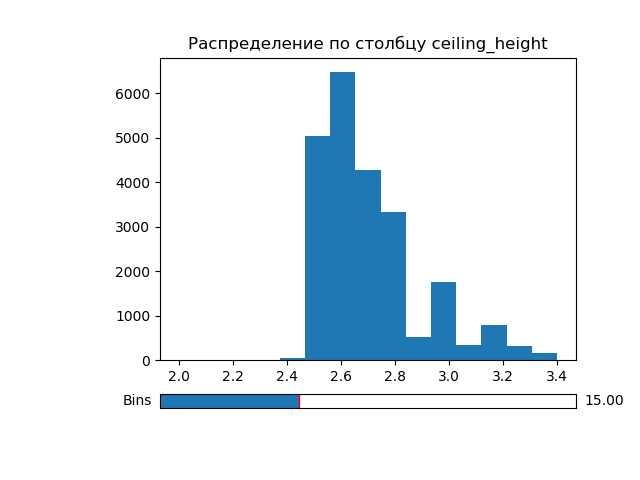

In [83]:
DrawHist('ceiling_height', scope=3)

Переходим к заданиям.

Рассмотрим время продажи квартиры

In [84]:
realty.days_published.describe()

count    20327.000000
mean       180.755006
std        219.652570
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_published, dtype: float64

Половина квартир продается меньше, чем за три месяца, половина дольше. При это среднее время продажи около полугода.

Посмотрим на ящик с усами (функция ругается на пропуски, которые я оставил намеренно, посему для анализа вводится дополнительная переменная)

In [85]:
days_before_sale = realty.days_published.dropna() 

<IPython.core.display.Javascript object>


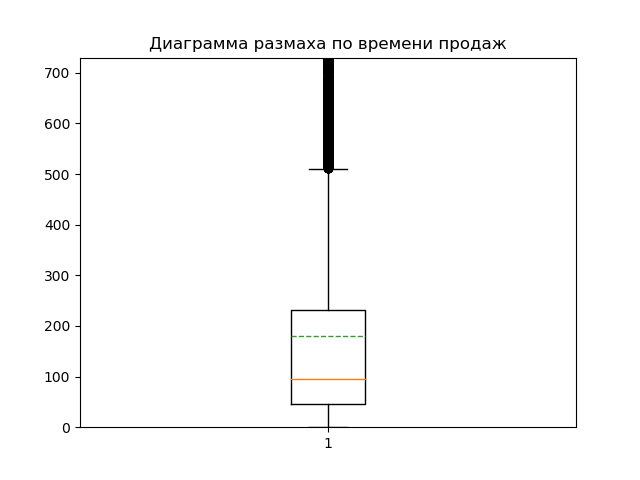

Text(0.5, 1.0, 'Диаграмма размаха по времени продаж')

In [86]:
plt.figure()
plt.boxplot(days_before_sale, showmeans=True,  meanline=True)
plt.gca().set_ylim(bottom=0, top=365*2)
plt.title('Диаграмма размаха по времени продаж')

За 2 года продается подавляющее большинство квартир. Посмотрим подробнее на распределение, построив гистограмму:

<IPython.core.display.Javascript object>


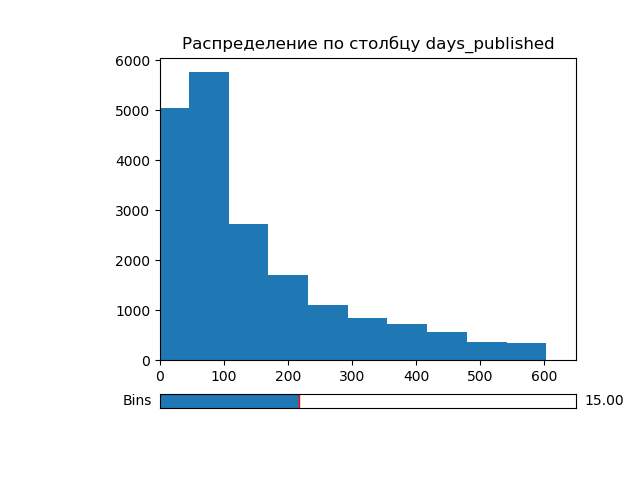

In [87]:
DrawHist('days_published', nan_present=True, has_negatives=False)

График подтверждает наши выводы. Посмотрим немного более подробно:

In [88]:
days_before_sale = realty.days_published.dropna() 
days_before_sale.describe(percentiles=[.1, .25, .5, .75, .9])

count    20327.000000
mean       180.755006
std        219.652570
min          1.000000
10%         17.000000
25%         45.000000
50%         95.000000
75%        231.000000
90%        460.000000
max       1580.000000
Name: days_published, dtype: float64

Таким образом, можно заключить, что если сделка прошла менее, чем за 3 недели, можно считать ее необычно быстрой (почти 90% продаж занимают больше времени), если же с момента размещения объявления до момента продажи прошло более полутора лет, сделку можно считать необычно долгой (около 90% продаж совершаются быстрее).

По описательным данным выше видим очень большое стандартное отклонение. Для дальнейшего анализа может быть полезно убрать выдающиеся значения. Нижнюю границу установим в одну неделю, верхнюю в два года. Предварительно оценим масштаб удаляемых данных.

In [89]:
len(days_before_sale[(days_before_sale < 7) | (days_before_sale > 730)])

1354

In [90]:
days_before_sale[(days_before_sale > 7) & (days_before_sale < 730)].describe()

count    18740.000000
mean       157.414621
std        156.597377
min          8.000000
25%         45.000000
50%         96.000000
75%        216.000000
max        729.000000
Name: days_published, dtype: float64

Видим, что это повлияет разве что на среднее. Считаю нецелесообразным избавляться от такого количества данных. График в его текущем виде похож на распределение Пуассона, что является хорошим знаком - оно описывает число событий в единицу времени, для продаж это вполне подходит.

Исследуем, какие факторы могут влиять на цену, рассчитав корреляцию с основными параметрами.

In [91]:
realty_wo_extreme_prices = realty[(realty.price_too_high == False) & (realty.price_too_low == False)]

График

In [92]:
realty2 = realty[realty.downtown_dist != -1]

<IPython.core.display.Javascript object>


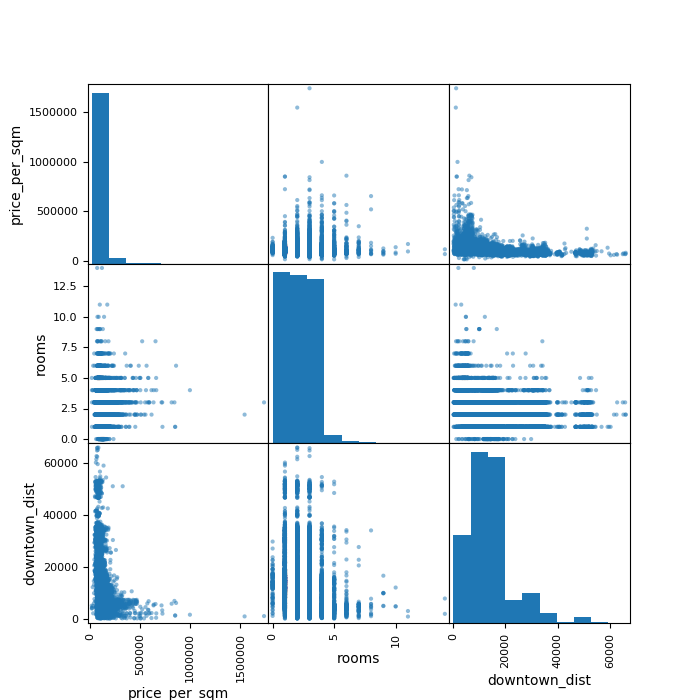

Text(0.5, 1.0, '')

In [93]:
pd.plotting.scatter_matrix(realty2[['price_per_sqm','rooms','downtown_dist']], figsize=(7,7))
plt.title('') # эта строка убирает ndarray из-под графика
# и да, он большеват, но зато снизу названия влезают + лучше читабельность

Заметно, что в районах, близких к центру, больше дорогих квартир и в больше "многокомнатных" квартир. Теперь посчитаем коэффициенты корреляции, чтобы лучше оценить связи между параметрами

In [94]:
print(realty.price_per_sqm.corr(realty.total_area))
print(realty_wo_extreme_prices.price_per_sqm.corr(realty_wo_extreme_prices.total_area))

0.28925242994194034
-0.04915494852114551


Есть не очень сильная корреляция между ценой квадратного метра и площадью, но она практически не присутствует, если исключить самые дорогие и дешевые квартиры

In [95]:
print(realty.price_per_sqm.corr(realty.rooms))
print(realty_wo_extreme_prices.price_per_sqm.corr(realty_wo_extreme_prices.rooms))

0.038668702775861305
-0.2077703413457495


В общей выборке практически нет нет связи между количеством комнат и стоимостью квадратного метра. Однако если исключить объкты с наибольшей и наименьшей стоимостью, появляется небольшая отрицательная корреляция, т.е. квартиры, где больше комнат, могут стоить немного дешевле в пересчете на единицу площади.

In [96]:
print(realty.price_per_sqm.corr(realty[realty.downtown_dist != -1].downtown_dist)) # искл. заполненные ранее -1 пропуски
print(realty_wo_extreme_prices.price_per_sqm.corr(
    realty_wo_extreme_prices[realty_wo_extreme_prices.downtown_dist != -1].downtown_dist))

-0.32986848294116644
-0.39066223722928417


Наблюдаем небольшую отрицательную корреляцию, которая становится еще немного больше при исключении из выборки  самой дорогой и дешевой недвижимости. Т.е. при уменьшении расстояния до центра стоимость квадратного метра растет. Логично.

In [97]:
realty.groupby('floor_kind').price_per_sqm.median().round(decimals=2).sort_values()

floor_kind
first    81258.61
top      87771.20
other    98305.08
Name: price_per_sqm, dtype: float64

Видим, что самые дешевые квартиры расположены на первом этаже, дороже на последнем, самые дорогие - промежуточные этажи, не первый и не последний. Звучит правдоподобно.

In [98]:
corr_matrix = realty.corr()
corr_matrix

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,balconies,airport_dist,downtown_dist,parks_around3000,park_dist,ponds_around3000,pond_dist,days_published,price_per_sqm,living_to_total,kitchen_to_total,price_too_low,price_too_high
total_images,1.000000,0.126031,0.122601,0.099624,0.057383,0.008960,0.105855,0.031823,0.011790,-0.028300,-0.024529,0.112165,0.046087,0.040047,0.002252,0.037399,0.028601,0.011274,0.010060,-0.027687,0.135313,-0.002084,-0.029486,-0.042541,0.091418
last_price,0.126031,1.000000,0.687862,0.400624,0.446007,-0.007660,0.613751,0.021646,0.028711,-0.031874,-0.010465,0.529525,0.003147,0.138698,-0.056135,0.256070,0.150335,0.252412,0.109628,0.113084,0.775477,0.007424,-0.107646,-0.106443,0.652068
total_area,0.122601,0.687862,1.000000,0.779516,0.555360,-0.079217,0.938872,-0.032356,0.022425,-0.078380,-0.037234,0.606309,0.013176,0.097302,-0.077334,0.213719,0.128274,0.210465,0.096908,0.162697,0.289252,0.150214,-0.352784,-0.095860,0.627173
rooms,0.099624,0.400624,0.779516,1.000000,0.362323,-0.230987,0.849142,-0.155751,-0.001831,-0.148978,-0.088553,0.276432,-0.015297,0.047432,-0.057892,0.158969,0.082287,0.121062,0.059056,0.127047,0.038669,0.475538,-0.597875,-0.066723,0.358991
ceiling_height,0.057383,0.446007,0.555360,0.362323,1.000000,-0.069212,0.514101,-0.034485,0.054265,-0.010267,-0.017698,0.429912,-0.057307,0.061978,-0.134515,0.248154,0.140832,0.238389,0.109266,0.123764,0.325125,0.008994,-0.072216,-0.072065,0.390844
floors_total,0.008960,-0.007660,-0.079217,-0.230987,-0.069212,1.000000,-0.167789,0.677684,-0.024187,0.070290,0.049533,0.143940,0.173196,0.162936,0.096525,-0.158981,-0.063185,-0.049696,0.016382,-0.051963,0.155072,-0.349629,0.338323,-0.157652,-0.052694
living_area,0.105855,0.613751,0.938872,0.849142,0.514101,-0.167789,1.000000,-0.099721,0.021856,-0.059055,-0.027689,0.425647,-0.010059,0.073158,-0.081641,0.217949,0.113909,0.190447,0.089793,0.152857,0.212493,0.430457,-0.504725,-0.076666,0.555930
floor,0.031823,0.021646,-0.032356,-0.155751,-0.034485,0.677684,-0.099721,1.000000,-0.012150,0.036005,0.034684,0.119044,0.171541,0.108962,0.061203,-0.105659,-0.040107,-0.030245,0.012772,-0.038826,0.131343,-0.254028,0.236518,-0.105372,-0.002893
is_apartment,0.011790,0.028711,0.022425,-0.001831,0.054265,-0.024187,0.021856,-0.012150,1.000000,-0.003505,-0.002352,0.041151,0.029836,0.016384,0.011474,0.017298,-0.011209,0.023865,0.019750,0.014006,0.038369,0.004208,0.014494,-0.007345,0.016458
is_studio,-0.028300,-0.031874,-0.078380,-0.148978,-0.010267,0.070290,-0.059055,0.036005,-0.003505,1.000000,-0.004200,-0.058747,0.030160,-0.031340,-0.021095,-0.032176,-0.024160,-0.009246,-0.004980,-0.021621,0.016516,0.089642,0.050763,0.000319,-0.015597


<IPython.core.display.Javascript object>


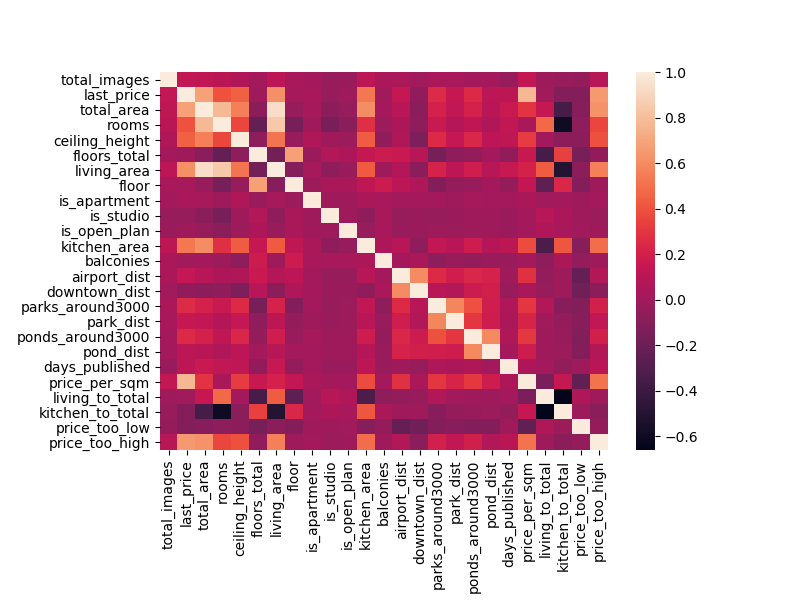

In [99]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.2, bottom=0.25)
sns.heatmap(corr_matrix)

Теперь посмотрим, есть ли зависимость цены от времени размещения: дня недели, месяца и года.

In [100]:
realty.groupby(by=lambda idx: realty.published_on[idx].weekday()).price_per_sqm.median().round(decimals=2)

0    94765.59
1    95588.24
2    95454.55
3    95190.38
4    94607.59
5    93525.74
6    94727.78
Name: price_per_sqm, dtype: float64

Видим, что в начале недели размещают немного более дорогие квартиры, а в выходные дни наоборот, более дешевые

In [101]:
price_by_month = realty.groupby(by=lambda idx: realty.published_on[idx].month).price_per_sqm.median().round(decimals=2)
price_by_month

1     95186.52
2     95000.00
3     95391.81
4     96451.61
5     92696.63
6     92896.17
7     95063.99
8     96153.85
9     95599.69
10    94202.90
11    95625.00
12    94254.17
Name: price_per_sqm, dtype: float64

Глядя на цифры, сложно сказать, тут нам поможет график:

<IPython.core.display.Javascript object>


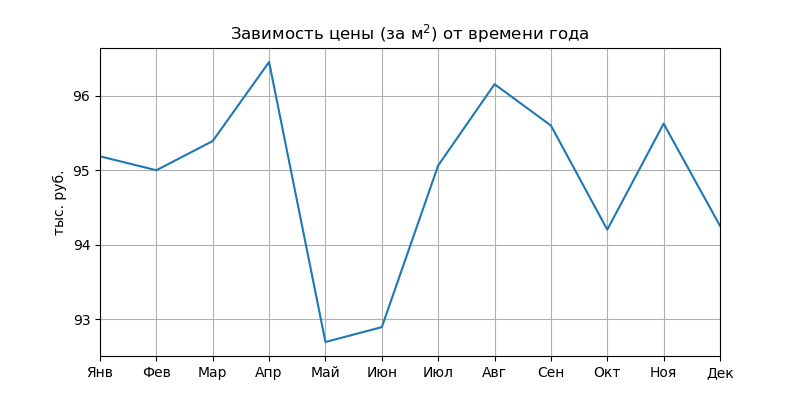

In [102]:
plt.figure(figsize=(8,4))
plt.xlim(1,12)
plt.plot(price_by_month)
plt.yticks([i*1000 for i in range(93, 97)], labels=[i for i in range(93,97)])
plt.ylabel('тыс. руб.')
plt.xticks([i for i in range(1,13)], labels=['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек'])
plt.title('Завимость цены (за м$^2$) от времени года')
plt.grid()

По графику можно сказать, что цена претерпевает не слишком значительные изменения в течение всего года, более всего заметно снижение в мае-июне.

Теперь изучим изменения цен по годам:

In [103]:
realty.groupby(by=lambda idx: realty.published_on[idx].year).price_per_sqm.median().round(decimals=2)

2014    106901.90
2015     93333.33
2016     91743.12
2017     92558.56
2018     95758.07
2019    103328.87
Name: price_per_sqm, dtype: float64

Здесь заметно снижение цен после 2014 года с минимумом в 2016 году и практически полным восстановлением прежнего уровня к 2019 году. Причина вполне очевидна - с 2014 года в стране был финансовый кризис.

In [104]:
top_list = realty.groupby('short_city_name').count()['total_images'].sort_values(ascending=False).index[:10]

In [105]:
top_cities = realty[realty.short_city_name.isin(top_list)] \
.groupby('short_city_name').mean()['price_per_sqm'].round(decimals=2).sort_values(ascending=False)
top_cities

short_city_name
санкт-петербург    114544.91
пушкин             103125.82
кудрово             95261.96
парголово           90175.91
мурино              86018.11
шушары              78551.34
колпино             75424.58
гатчина             68757.68
всеволожск          68719.32
выборг              58238.14
Name: price_per_sqm, dtype: float64

Самая дорогая недвижимость ожидаемо в Санкт-Петербурге, самая дешевая - в Выборге.

<IPython.core.display.Javascript object>


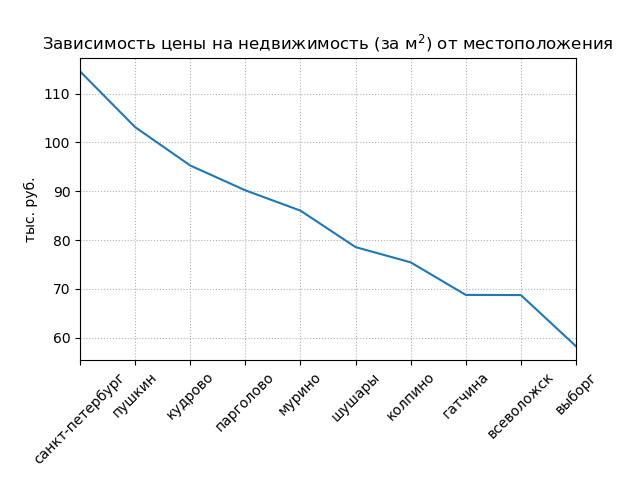

In [106]:
plt.figure()
plt.plot(top_cities)
plt.xticks(top_list, rotation=45)
plt.subplots_adjust(bottom=0.25)
plt.xlim(0,9)
plt.yticks([i*1000 for i in range(60, 120, 10)], labels=[i for i in range(60, 120, 10)])
plt.ylabel('тыс. руб.')
plt.title('Зависимость цены на недвижимость (за м$^2$) от местоположения')
plt.grid(linestyle=':')

<font color=orange>Лучше использовать диаграмму, т.к. значения по оси X не связаны. 
    
---

*Задание: Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.*

In [107]:
sp_selected = realty[(realty.short_city_name == 'санкт-петербург') & (realty.downtown_dist != -1)].copy()
sp_selected['downtown_rounded'] = np.around(sp_selected['downtown_dist'] / 1000).astype('uint32')
price_by_dt_dist = sp_selected.groupby('downtown_rounded').mean()['price_per_sqm']

<IPython.core.display.Javascript object>


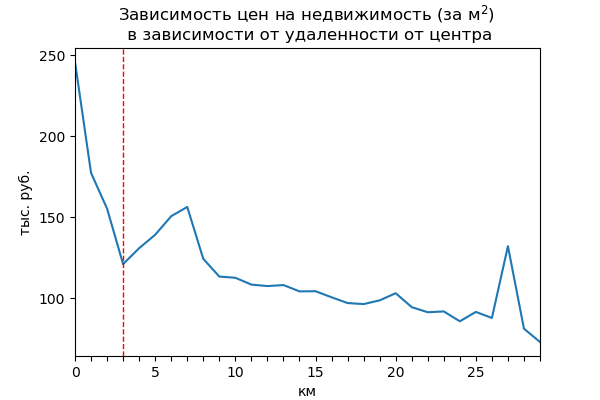

In [108]:
plt.figure(figsize=(6,4))
plt.xlim(0,29)
plt.plot(price_by_dt_dist)
plt.title('Зависимость цен на недвижимость (за м$^2$) \n в зависимости от удаленности от центра')
plt.yticks([100000,150000,200000,250000], labels=[100,150,200,250])
plt.ylabel('тыс. руб.')
plt.xticks([i for i in range(30)], labels=[i if i%5 == 0 else None for i in range(29)])
plt.xlabel('км')
plt.axvline(3, linestyle='--', lw=1, color='red')

Центральная зона, судя по графику, составляет около 3 км от центра

*Задание: Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?*

In [109]:
realty_center = sp_selected[sp_selected.downtown_rounded <= 3]

In [110]:
drop_center = realty_center.total_area.dropna()

In [111]:
mean_area_all = np.round(realty.total_area.mean(), decimals=2)
mean_area_center = np.round(realty_center.total_area.mean(), decimals=2)
print('Средняя площадь всех квартир составляет {} м\u00B2'.format(mean_area_all))
print('Средняя площадь квартир в центре составляет {} м\u00B2, на {:.2%} больше'.format(
mean_area_center, mean_area_center / mean_area_all - 1))

Средняя площадь всех квартир составляет 59.85 м²
Средняя площадь квартир в центре составляет 97.07 м², на 62.19% больше


<IPython.core.display.Javascript object>


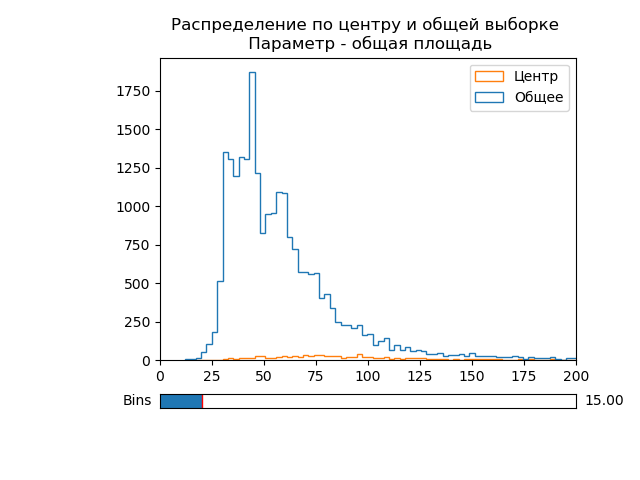

In [112]:
DrawHist(realty.total_area, scope=3, has_negatives=False, is_from_table=False, 
         second_datum=realty_center.total_area, descr='общая площадь', restrict_right=200)

In [113]:
print('Среднее количество комнат среди всех квартир - ', int(realty.rooms.mean()))
print('Среднее количество комнат среди квартир в центре - ', int(realty_center.rooms.mean()))

Среднее количество комнат среди всех квартир -  2
Среднее количество комнат среди квартир в центре -  3


<IPython.core.display.Javascript object>


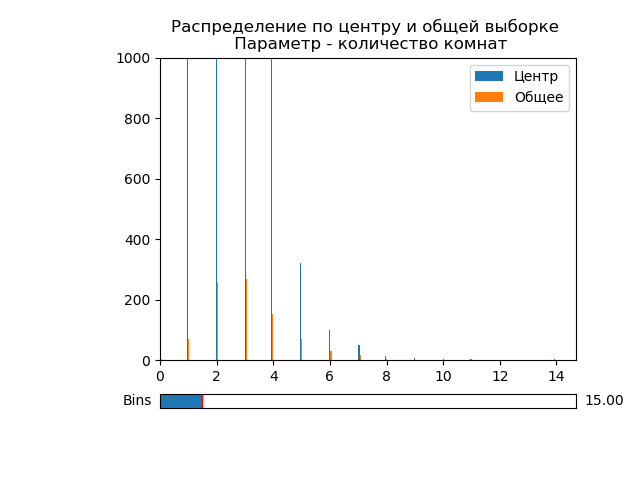

In [114]:
DrawHist(realty.rooms, has_negatives=False, is_from_table=False, second_datum=realty_center.rooms, 
         descr='количество комнат', restrict_top=1000, kind='bar') # ВНИМАНИЕ! ставим bins на минимум, тогда читабельно

# хотел добавить в функцию возможность менять дефолт по bins через кварг, но она и без того ими загружена

In [115]:
mean_ceiling_all = np.round(realty.ceiling_height.mean(), decimals=2)
mean_ceiling_center = np.round(realty_center.ceiling_height.mean(), decimals=2)
print('Средняя высота потолков среди всех квартир - {} м'.format(mean_ceiling_all))
print('Средняя высота потолков среди квартир в центре - {} м, на {:.2%} больше'.format(
mean_ceiling_center, mean_ceiling_center / mean_ceiling_all - 1))

Средняя высота потолков среди всех квартир - 2.73 м
Средняя высота потолков среди квартир в центре - 3.12 м, на 14.29% больше


<IPython.core.display.Javascript object>


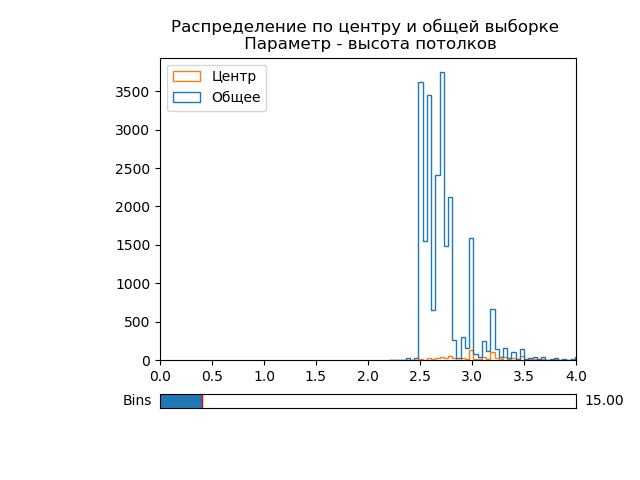

In [116]:
DrawHist(realty.ceiling_height, has_negatives=False, is_from_table=False, second_datum=realty_center.ceiling_height,
        descr='высота потолков', restrict_right=4)

# здесь тоже лучше на минимуме bins читается, + можно через restrict_top его сверху порезать, чтоб рассмотреть "центр"
# опять же, можно при необходимости научить функцию резать еще и слева

In [117]:
mean_price_all = np.round(realty.last_price.mean() / 1000, decimals=2)
mean_price_center = np.round(realty_center.last_price.mean() / 1000, decimals=2)
print('Средняя цена среди всех квартир составляет примерно {} млн. руб.'.format(mean_price_all))
print('Средняя цена среди квартир в центре составляет примерно {} млн. руб., в {:.2} раза больше'.format(
    mean_price_center, mean_price_center / mean_price_all))

Средняя цена среди всех квартир составляет примерно 6.39 млн. руб.
Средняя цена среди квартир в центре составляет примерно 15.73 млн. руб., в 2.5 раза больше


<IPython.core.display.Javascript object>


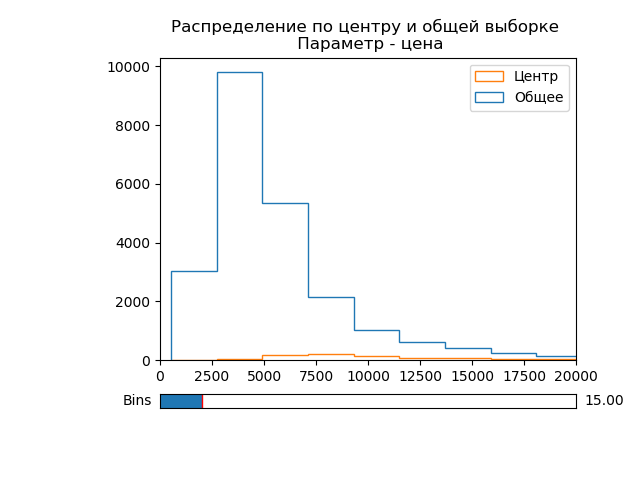

In [118]:
DrawHist(realty.last_price, has_negatives=False, is_from_table=False, second_datum=realty_center.last_price,
        descr='цена', restrict_right=20000)

Интересно сравнить долю очень дорогих квартир в центре и в целом по выборке (в процентах)

In [119]:
print('Доля очень дорогих квартир в целом по выборке {:.2%}'.format(realty.price_too_high.mean()))
print('Доля очень дорогих квартир в центре {:.2%}'.format(realty_center.price_too_high.mean()))

Доля очень дорогих квартир в целом по выборке 4.97%
Доля очень дорогих квартир в центре 23.74%


Вполне закономерный результат

Сравниваем корреляции в целом по выборке и в центре.


<IPython.core.display.Javascript object>


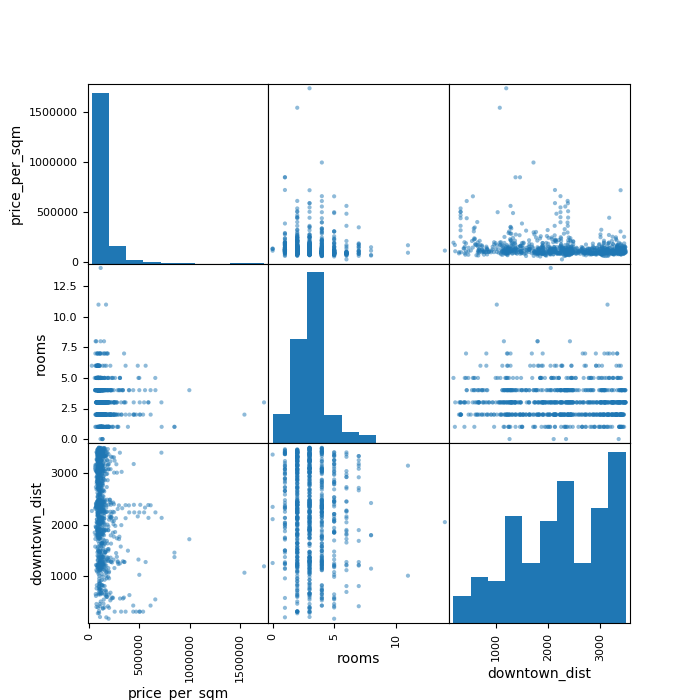

Text(0.5, 1.0, '')

In [120]:
pd.plotting.scatter_matrix(realty_center[['price_per_sqm','rooms','downtown_dist']], figsize=(7,7))
plt.title('') # эта строка убирает ndarray из-под графика

Поскольку мы работаем с квартирами из центра, что уже является фактором роста цен и количества комнат, зависимости между этиими параметрами не так заметны, как в общей выборке.

Корреляции между ценой и количеством комнат:

In [121]:
print(realty_center.price_per_sqm.corr(realty_center.rooms)) # центр
print(realty.price_per_sqm.corr(realty.rooms)) # общий

-0.05673704671519873
0.038668702775861305


Особой разницы нет.

Корреляции между ценой и расстоянием до центра

In [122]:
print(realty_center.price_per_sqm.corr(realty_center.downtown_dist))
print(realty.price_per_sqm.corr(realty[realty.downtown_dist != -1].downtown_dist)) # общий

-0.20189263876566177
-0.32986848294116644


Тоже без существенной разницы.

Зависимость цены от этажа:

In [123]:
floor = pd.DataFrame({'Центр':realty_center.groupby('floor_kind').price_per_sqm.median().round(decimals=2),
              'Общее':realty.groupby('floor_kind').price_per_sqm.median().round(decimals=2)})
floor

,Центр,Общее
floor_kind,,
first,108027.78,81258.61
other,121568.63,98305.08
top,115789.47,87771.20


<IPython.core.display.Javascript object>


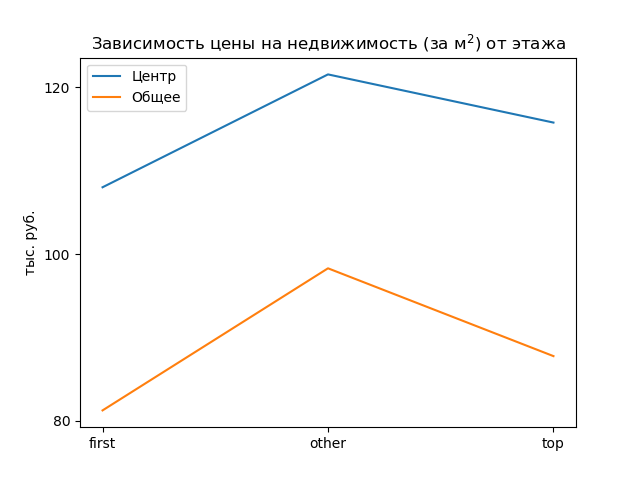

In [124]:
plt.figure()
plt.plot(floor)
plt.yticks([i*1000 for i in range(80, 121, 20)], labels=[i for i in range(80, 121, 20)])
plt.ylabel('тыс. руб.')
plt.title('Зависимость цены на недвижимость (за м$^2$) от этажа')
plt.legend(['Центр','Общее'])

Зависимости от дня недели

In [125]:
week = pd.DataFrame({'Центр':realty_center.groupby(
    by=lambda idx: realty_center.published_on[idx].weekday()).price_per_sqm.median().round(decimals=2),
                    'Общее':realty.groupby(
    by=lambda idx: realty.published_on[idx].weekday()).price_per_sqm.median().round(decimals=2),
                    'День недели':['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье']})
week = week.set_index('День недели')
week

,Центр,Общее
День недели,,
Понедельник,125681.13,94765.59
Вторник,112764.23,95588.24
Среда,116981.13,95454.55
Четверг,115577.18,95190.38
Пятница,121590.91,94607.59
Суббота,123636.36,93525.74
Воскресенье,109890.11,94727.78


<IPython.core.display.Javascript object>


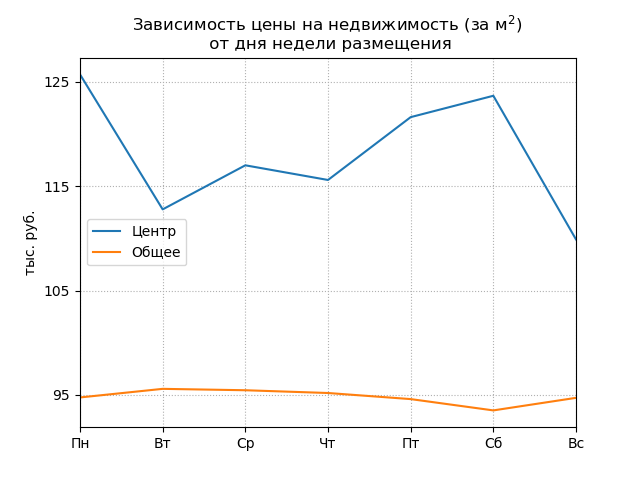

In [126]:
plt.figure()
plt.plot(week)
plt.title('Зависимость цены на недвижимость (за м$^2$) \n от дня недели размещения')
plt.xticks([i for i in range(len(week))], labels=['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
plt.yticks([i*1000 for i in range(95, 135, 10)], labels=[i for i in range(95, 135, 10)])
plt.ylabel('тыс. руб.')
plt.legend(['Центр','Общее'])
plt.xlim(0,6)
plt.grid(True, linestyle=':')

В отличие от общей выборки, где происходит небольшое повышение цены в середине недели и небольшое падение к выходным, в центральной части наблюдается намного большие изменения, при этом в середине недели происходит падение цен, а в пятницу-субботу, наоборот, повышение

Зависимость от года:

In [127]:
year_df = pd.DataFrame({'Общее': realty.groupby(
    by=lambda idx: realty.published_on[idx].year).price_per_sqm.median().round(decimals=2),
             'Центр': realty_center.groupby(
    by=lambda idx: realty.published_on[idx].year).price_per_sqm.median().round(decimals=2)})
year_df

,Общее,Центр
2014,106901.90,278099.65
2015,93333.33,107981.04
2016,91743.12,106122.45
2017,92558.56,116852.77
2018,95758.07,123529.41
2019,103328.87,133333.33


<IPython.core.display.Javascript object>


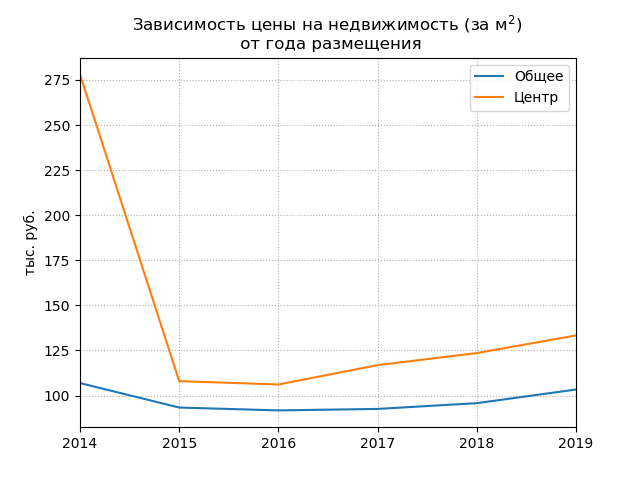

In [128]:
plt.figure()
plt.plot(year_df)
plt.title('Зависимость цены на недвижимость (за м$^2$) \n от года размещения')
plt.yticks([i*1000 for i in range(100, 300, 25)], labels=[i for i in range(100, 300, 25)])
plt.ylabel('тыс. руб.')
plt.legend(['Общее','Центр'])
plt.xlim(2014,2019)
plt.grid(True, linestyle=':')

Зависимость цен от времени года:

In [129]:
center_price_by_month = realty_center.groupby(
    by=lambda idx: realty_center.published_on[idx].month).price_per_sqm.median().round(decimals=2)

In [130]:
month = pd.DataFrame({'Центр': center_price_by_month, 'Общее': price_by_month,
                     'Месяц': ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']})
month = month.set_index('Месяц')

In [131]:
month

,Центр,Общее
Месяц,,
Январь,123529.41,95186.52
Февраль,118000.00,95000.00
Март,120584.49,95391.81
Апрель,126984.13,96451.61
Май,110157.06,92696.63
Июнь,117234.38,92896.17
Июль,114655.17,95063.99
Август,111696.20,96153.85
Сентябрь,116438.29,95599.69


<IPython.core.display.Javascript object>


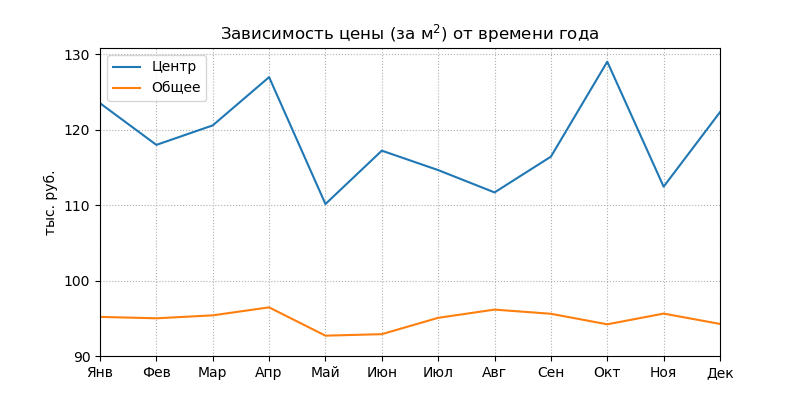

In [132]:
plt.figure(figsize=(8,4))
plt.plot(month.iloc[:, [0,1]])
plt.xlim(0,11)
plt.xticks([i for i in range(12)], labels=['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек'])
plt.grid(True, linestyle=':')
plt.yticks([90000, 100000, 110000, 120000, 130000], labels=[90,100,110,120,130])
plt.ylabel('тыс. руб.')
plt.title('Зависимость цены (за м$^2$) от времени года')
plt.legend(['Центр','Общее'])

В центральной части города цены изменяются гораздо сильнее в течение года. В летние месяцы имеется тренд к снижению цен в обеих выборках, но в центре он выражен сильнее и длится дольше. Это может быть связано с тем, что летом многие берут отпуска, и недвижимость продается не так активно.

#### Вывод

Стоимость в квадратного метра в центре существенно выше - более, чем на 60%, чем в целом по городу и области, а сами квартиры стоят более, чем втрое дороже, причем доля очень дорогих квартир почти впятеро выше в центральной части, чем в среднем по выборке. Близкая к центру недвижимость имеет в среднем на одну комнату больше и на 12,5% более высокие потолки. Особой разницы с общей выборкой в части зависимости цены квадратного метра не замечено, сохраняется зависимость от этажа - как и везде, наименее ценятся квартиры на первом этаже, чуть более - те, что на последнем, не относящиеся же ни к одной из вышеперечисленных категорий имеют наибольшую среднюю стоимость.

Также было замечено, что цены в центральной части более изменивы, возможно, потому, что более богатые резиденты этих районов чаще других берут отпуска в летний период, отсюда больший провал по ценам.

### Шаг 5. Общий вывод

В ходе проекта был изучен архив объявлений о продаже квартир в Санкт-Петербурге. Во время предобработки были замечены многочисленные пропуски для таких данных, как, например, высота потолков, количество балконов или площадь кухни. Это может быть связано с тем, что эти данные заполняли пользователи, и многие не знали или не захотели указать эти параметры. В большинстве случаев пропуски были устранены, кроме количества дней до продажи - в данном случае пропуск может свидетельствовать о том, что квартира еще не была продана.

Большинство квартир имеют площадь от 20 до 80 квадратных метров, от одной до трех комнат, цену от 3 до 5 миллионов рублей, невысокие потолки - таким образом, можно сказать, что покупают в основном жилье эконом-класса.

Квартиры дорожают тем больше, чем ближе они к центру города, при этом самое дорогое жилье расположено в радиусе трех километров от центра. Квартиры там стоят в среднем в 2,5 раза дороже, имеют больше комнат и более высокие потолки. Доля очень дорогих квартир в центре почти впятеро превышает таковую у общей выборки. В этой области корреляции между ценой за единицу площади и некоторыми параметрами, например, число комнат, расстояние до центра, менее выражено, чем в общей выборке. Можно сказать, что если квартира расположена в центральной части, то не так важно, где именно в центре, внутри этого среза данные распределены более равномерно. В то же время для такой недвижимости отмечается больший разброс цен в течение года, наиболее заметен спад в течение летнего периода. Похожая корреляция была замечена и в общей выборке, но для квартир в центре спад цен в летние месяцы глубже, и длится он дольше. Это может быть связано с тем, что в таких районах проживает преимущественно богатое население, которое может позволить себе, к примеру, длительный заграничный отпуск, и в такое время активность на рынке снижается.

Также было отмечено, что в отличие от общей выборки, где происходит небольшое повышение цен в середине недели и падение к выходным, в центральной части наблюдается намного большие изменения, при этом в середине недели происходит падение цен, а в пятницу-субботу, наоборот, повышение. Точную причину такой корреляции выделить трудно, возможно, в центральной части больше бизнесменов, руководителей, которые на неделе заняты работой, а вечером пятницы или в субботу находят время, чтобы разместить объявление. Но это всего лишь гипотеза.

Есть и корреляции, не зависящие от "центральности" жилья. Так, в обеих выборках квартиры на первых этажах имеют наименьшую стоимость, а те, что не расположены ни на первом, ни на последнем - наибольшую. Причины этого могут быть разные, к примеру, на первом этаже отталкивающими факторами могут быть холодные полы или отсутствие балкона, на последнем же этаже может, например, прохудиться кровля, а если сломается лифт, придется долго подниматься наверх.

Очень интересную зависимость удалось выделить между уровнем цен по различным годам. В обеих выборках цены упали после 2014 года, как известно, именно в это время экономическая ситуация в стране ухудшилась, что отразилось в том числе и на рынке недвижимости. Но если в целом цены к 2019 году практически вернулись к дотянув до докризисному уровню, то рынок недвижимости в центральной части, где, как отмечалось выше, доля "элитного" жилья многократно выше, хоть и демонстрирует стабильный рост с 2015 года, так и не смог отыграть более чем двукратное падение 2014-го. Можно говорить о том, что дорогое жилье более чувствительно к такого рода встряскам. Кстати, было бы интересно взглянуть на подобную таблицу через год-два, сможем ли мы там видеть столь же значительное влияние кризиса.